In [1]:
import functools
import geopy
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests
import scipy as sp
import rtree
import seaborn as sb
from scipy import signal
# import shapely
import shapely.geometry
%pylab inline

import data_munging

Populating the interactive namespace from numpy and matplotlib


In [2]:
rides, readings = data_munging.read_raw_data()
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

In [7]:
readings['time_diff'] = readings['end_time'] - readings['start_time']

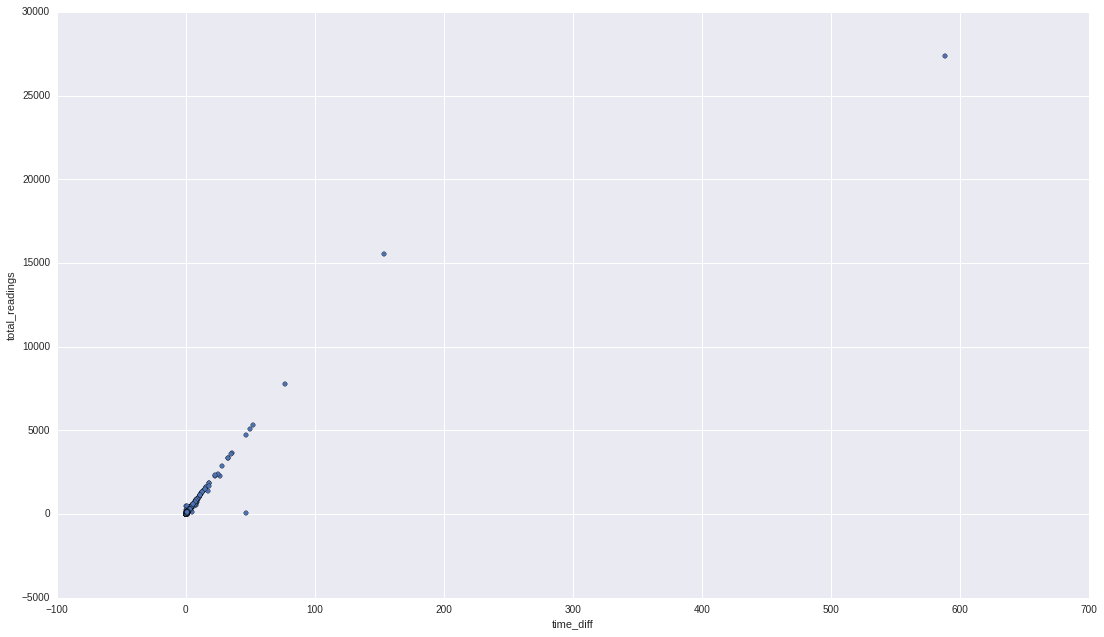

In [11]:
readings.plot(x='time_diff', y='total_readings', kind='scatter')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [4]:
n, p = readings.shape
print rides.columns
print readings.columns

Index([u'id', u'created_at', u'updated_at', u'start_time', u'end_time',
       u'calibration_id', u'scoreboard_id'],
      dtype='object')
Index([u'id', u'created_at', u'updated_at', u'start_lat', u'start_lon',
       u'end_lat', u'end_lon', u'acceleration_x', u'acceleration_y',
       u'acceleration_z', u'angle_x', u'angle_y', u'angle_z', u'ride_id',
       u'start_time', u'end_time', u'mean_g', u'num_accel_x', u'abs_sum_x',
       u'std_x', u'num_accel_y', u'abs_sum_y', u'std_y', u'num_accel_z',
       u'abs_sum_z', u'std_z', u'std_total', u'gps_dist', u'num_accel_total',
       u'abs_sum_total', u'gps_speed', u'total_readings', u'start_x',
       u'start_y', u'end_x', u'end_y', u'bb'],
      dtype='object')


In [37]:
readings_idx = data_munging.insert_readings_rtree(readings)

In [114]:
reload(data_munging)

<module 'data_munging' from 'data_munging.py'>

In [61]:
type(readings['start_x'][0])

numpy.float64

This is currently randomly sampling points, making a small bounding box, and checking for intersecting. Perhaps we should also include a mitre-ing component and add shapely to make this comparison??

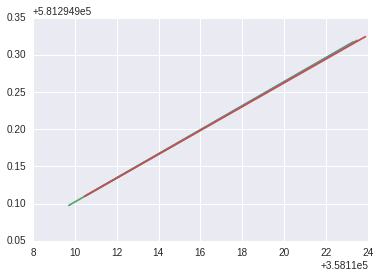

In [153]:
total_intersections = []
for sample_in in range(1000):
    random_idx, random_point = data_munging.select_random_point(readings)
    random_bb = data_munging.point_to_bb(*random_point, side_length=0.2)
    intersecting_segments = list(readings_idx.intersection(random_bb))
#     segments = [[(readings['start_x'][i], readings['end_x'][i]), (readings['start_y'][i], readings['end_y'][i])] for i in intersecting_segments]
    intersecting_segments = [i for i in intersecting_segments if data_munging.calc_reading_diffs(readings.ix[i, :], readings.ix[random_idx, :]) < 0.5]
    if len(intersecting_segments) > 1:
        for i in intersecting_segments:
            plt.plot([readings.ix[i, 'start_x'], readings.ix[i, 'end_x']], [readings.ix[i, 'start_y'], readings.ix[i, 'end_y']])
#         line_coll = mc.LineCollection(segments)
#         fig, ax = plt.subplots()
#         ax.add_collection(line_coll)
#         ax.autoscale()
#         ax.margins(0.1)
#         plt.show()
        plt.show()
        break
#     plot = readings.ix[intersecting_segments, :].plot(x='start_x', y='start_y', kind='scatter', c=var, colormap='Oranges')

In [57]:
intersecting_segments

[25927,
 25928,
 25929,
 25930,
 25931,
 25932,
 25933,
 25934,
 25640,
 25664,
 25280,
 25935,
 25936]

In [54]:
len(list(intersecting_segments))

0

In [51]:
random_bb

[1519759.6057959145, 547856.977901477, 1519759.8057959147, 547857.177901477]

In [22]:
transform_to_segment = lambda r: [(r['start_x'], r['end_x']), (r['start_y'], r['end_y'])]
line_coll_test = list(readings.loc[:1000, :].apply(transform_to_segment, axis=1))
    

array([ [358527.148244122, 358524.6614723406, (581744.6461771185, 581762.3756560954)],
       [358500.18938952434, 358498.68606768583, (581559.708198206, 581554.747381038)],
       [358498.68606768583, 358503.51181251626, (581554.747381038, 581559.1349860536)],
       ...,
       [357986.4808056747, 357986.76411488414, (581675.5786785388, 581667.2424534442)],
       [357986.76411488414, 357986.9164576596, (581667.2424534442, 581662.7595567708)],
       [357986.9164576596, 357987.8676594679, (581662.7595567708, 581660.6714736678)]], dtype=object)

KeyboardInterrupt: 

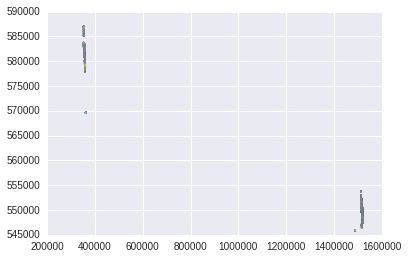

In [35]:
for i, r in readings.iterrows():
    plt.plot([r['start_x'], r['end_x']], [r['start_y'], r['end_y']])

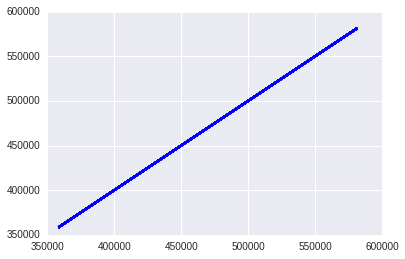

In [23]:
line_coll = mc.LineCollection(line_coll_test)
fig, ax = plt.subplots()
ax.add_collection(line_coll)
ax.autoscale()
plt.show()


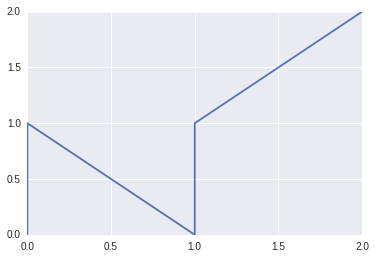

In [32]:
plt.plot([0, 0, 1, 1, 2], [0, 1, 0, 1, 2])
plt.show()

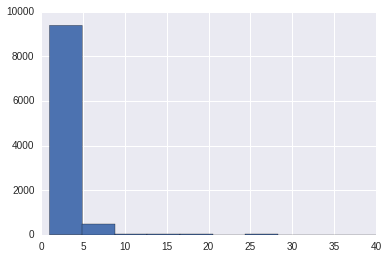

In [43]:
plt.hist(total_intersections)
plt.show()

In [ ]:
readings['gps_dist'].plot(kind='hist')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
print sp.stats.describe(readings['gps_dist'])
print np.percentile(readings['gps_dist'], 5)

In [ ]:
readings_idx = data_munging.insert_readings_rtree(readings)

In [ ]:
intersecting_segments = dict()
for i in readings.index:
    reading_of_interest = data_munging.expand_bb(readings_idx.get_bounds(i), 0.2)
    ins_readings = list(readings_idx.intersection())
    if len(ins_readings) > 0:
        intersecting_segments[i] = ins_readings    

In [ ]:
print readings_idx.get_bounds(0)
print data_munging.expand_bb(readings_idx.get_bounds(0), 0.2)

In [ ]:
shapely.geometry.LineString([(0, 0), (1, 1)])

In [ ]:
#we will take the intersection of these two mitred segments and then set a threshold for overlap
# similar to Jaccard similarity
#we can also take the angle between these two segments and use that to determine if 
#we should consider them the same (different angles)

In [ ]:
help(shapely.geometry.LineString)
shapely.geometry.LineString()

In [ ]:
for i in readings_idx.intersection(readings_idx.get_bounds(0)):
    print 
# print len(list(readings_idx.intersection(readings_idx.get_bounds(0))))

In [ ]:
help(readings_idx.intersection)

In [ ]:
data_munging.

In [ ]:
# Locations plotted on map with coloring based on std
plt.plot()
chi_readings.plot(x='start_x', y='start_y', kind='scatter')
plt.show()

In [ ]:
help(pd.DataFrame.plot)

In [ ]:
chi_readings = data_munging.filter_readings_to_chicago(readings)

In [ ]:
nyc_readings = data_munging.filter_readings_to_nyc(readings)

In [ ]:
print chi_readings.shape
print nyc_readings.shape
print readings.shape

In [ ]:
ax = sb.regplot(x="gps_speed", y="std_z", data=readings, scatter_kws={'alpha':0.3})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
# ax = sb.regplot(x="total_bill", y="tip", data=tips, scatter_kws={'alpha':0.3})

In [ ]:
ax = sb.regplot(x="gps_speed", y="std_z", data=readings, scatter_kws={'alpha':0.05})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
pylab.xlim([0, 40])
plt.show()
# ax = sb.regplot(x="total_bill", y="tip", data=tips, scatter_kws={'alpha':0.3})

In [ ]:
readings['gps_speed'].plot(kind='hist')
plt.show()

In [ ]:
for axis in ['x', 'y', 'z']:
    readings['std_' + axis].plot(kind='hist')
    fig = plt.gcf()
    fig.set_size_inches(10, 4)
    plt.show()

In [ ]:
sample_size = 100
indices = np.random.choice(n, sample_size)
for axis in ['x', 'y', 'z']:
    for i in indices:
        sb.tsplot(readings['num_accel_' + axis][i][0:100], alpha=0.05)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.xlabel('Accelerometer Values')
    plt.ylabel('Force (Gravities)')
    plt.title('Random sample of ' + str(sample_size) + ' ' + axis + ' Accelerometer Time Series')
    plt.show()

In [ ]:
sample_size = 1000
indices = np.random.choice(n, sample_size)
for axis in ['x', 'y', 'z']:
    for i in indices:
        f, Pxx_den = signal.periodogram(readings['num_accel_' + axis][i][0:100])
        plt.plot(f, Pxx_den)
        plt.title('Power Spectrum for ' + axis + ' axis')
        plt.xlabel('frequency [Hz]')
        plt.ylabel('Power Spectrum Density')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()